<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Notebook-Description" data-toc-modified-id="Notebook-Description-0.0.1">Notebook Description</a></span><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-0.0.1.1">Initialization</a></span></li></ul></li><li><span><a href="#Parameter-Estimation-Implementation" data-toc-modified-id="Parameter-Estimation-Implementation-0.0.2">Parameter Estimation Implementation</a></span><ul class="toc-item"><li><span><a href="#Simulate-Each-Parameter-Set" data-toc-modified-id="Simulate-Each-Parameter-Set-0.0.2.1">Simulate Each Parameter Set</a></span></li><li><span><a href="#Visualize-Initial-Best-Parameter-Fit" data-toc-modified-id="Visualize-Initial-Best-Parameter-Fit-0.0.2.2">Visualize Initial Best Parameter Fit</a></span></li></ul></li></ul></li></ul></li></ul></div>

### Notebook Description

This notebook walks through the implementation of a steepest-descent parameter estimation method using the Euclidean 2-norm as a cost function. The method is intended to be used after several steady-state parameterizations are created.

The implementation will be modular in form so as to allow the use of any $\mathbb{L}$-norm, in particular the 1-norm and the $\infty$-norm. Also in some circumstances, the Newton descent method can be used to greatly accelerate optimization.

#### Initialization

In [1]:
import os, sys
NotebookDirectory = os.path.split(os.getcwd())[0]
if NotebookDirectory not in sys.path:
    sys.path.append(NotebookDirectory)
import toolbox

In [2]:
SciPyModel = toolbox.sbml.importSBMLFile(toolbox.createSciPyModel())
SciPyModel = toolbox.simulation.writeODEFunction( SciPyModel )
SciPyModel = toolbox.sampling.createNullSpaceFunction(SciPyModel)

In [3]:
import numpy

SciPyModel.Parameters.MinimumValue = numpy.zeros(SciPyModel.Parameters.Quantity)
SciPyModel.Parameters.MaximumValue = numpy.ones(SciPyModel.Parameters.Quantity) * 2.
SciPyModel.SimulationData.Sensitivity.Global.NumSamples = 25

SciPyModel = toolbox.sampling.uniformNullSpaceSample( SciPyModel )

### Parameter Estimation Implementation

Before we begin, we need to generate a bogus data set for comparison. We will use several random datapoints for each species of the model across time.

The `BogusData` variable should be replaced by an input matrix of data from Excel or some variant. The model will then be simulated between the extents of the input data and output only at the required data points. This save both time and memory by minimizing the read/write operations of the process.

In [4]:
BogusTimeStart = 0
BogusTimeEnd = 10
BogusDataPoints = 10

BogusTime = numpy.linspace( BogusTimeStart, BogusTimeEnd, BogusDataPoints )
BogusData = numpy.random.rand( BogusDataPoints, SciPyModel.Species.Quantity )

SciPyModel.SimulationData.TimeStart = BogusTimeStart
SciPyModel.SimulationData.TimeEnd = BogusTimeEnd
SciPyModel.SimulationData.DataPoints = BogusDataPoints

Now since the model has been parameterized at a steady-state condition, in order to see any dynamic response the model must be knocked off this attractor. We do this here by creating a random vector of scalar constants in $[0,2]$ to act as the current initialization.

In [5]:
RandomInitialization = SciPyModel.Species.Value * numpy.random.rand(SciPyModel.Species.Quantity) * 2
SciPyModel.Species.Value = RandomInitialization

#### Simulate Each Parameter Set

Now the model must be first run with each parameter set to find the sets which are most optimal. First we create a function to calculate the squared-error using the 2-norm. This function can be easily replaced to use the 1,$\infty$-norm.

In [6]:
def TwoNorm( SimulationData, UserData):
    return numpy.sqrt( sum(sum(numpy.power( UserData - SimulationData, 2.))) )

In [7]:
CostList = []
for ix in range(SciPyModel.SimulationData.Sensitivity.Global.NumSamples):
    # Set current parameter set
    SciPyModel.Parameters.Value = SciPyModel.SimulationData.Sensitivity.Global.ParameterSets[ ix, : ]
    
    # Simulate model
    SciPyModel = toolbox.simulation.integrateODEFunction( SciPyModel )
    
    # Calculate cost
    CostList.append( TwoNorm( SciPyModel.SimulationData.Deterministic.Data, BogusData ) )

#### Visualize Initial Best Parameter Fit

After this initial heuristic search to find a candidate best parameter set, we can visualize the fit to see how it performed. Note that the 2-norm is very sensitive to outliers in the data.

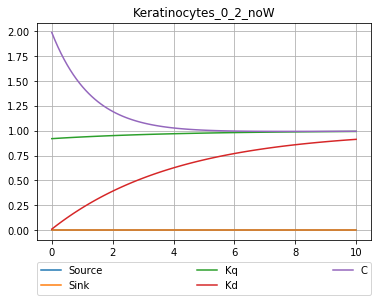

TypeError: Cannot cast array data from dtype('float64') to dtype('int64') according to the rule 'safe'

In [17]:
# Get index and cost of candidate best parameter set
BestCost, BestIndex = min((Cost, Index) for (Index, Cost) in enumerate(CostList))

# Replace parameter set in model
SciPyModel.Parameters.Value = SciPyModel.SimulationData.Sensitivity.Global.ParameterSets[ BestIndex, : ]
SciPyModel.SimulationData.DataPoints = 100
SciPyModel = toolbox.simulation.integrateODEFunction( SciPyModel )

toolbox.visuals.simplePlot(SciPyModel)

from matplotlib import pyplot as plt

plt.scatter( BogusTime.repeat(BogusData[1]).reshape(BogusData.shape), BogusData )

In [13]:
print BogusData.shape
print BogusTime.shape

(10, 5)
(10,)


array([[  0.        ,   0.        ,   0.        ,   0.        ,   0.        ],
       [  1.11111111,   1.11111111,   1.11111111,   1.11111111,
          1.11111111],
       [  2.22222222,   2.22222222,   2.22222222,   2.22222222,
          2.22222222],
       [  3.33333333,   3.33333333,   3.33333333,   3.33333333,
          3.33333333],
       [  4.44444444,   4.44444444,   4.44444444,   4.44444444,
          4.44444444],
       [  5.55555556,   5.55555556,   5.55555556,   5.55555556,
          5.55555556],
       [  6.66666667,   6.66666667,   6.66666667,   6.66666667,
          6.66666667],
       [  7.77777778,   7.77777778,   7.77777778,   7.77777778,
          7.77777778],
       [  8.88888889,   8.88888889,   8.88888889,   8.88888889,
          8.88888889],
       [ 10.        ,  10.        ,  10.        ,  10.        ,  10.        ]])